In [21]:
import torch
import torch.nn as nn
import numpy as np

In [22]:
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

# Generator

In [23]:
class Generator(nn.Module):
    def __init__(self , img_shape , latent_dim):
        super(Generator , self).__init__()
        self.img_shape = img_shape
        def block ( in_features , out_features , normalize = True):
            layers = [nn.Linear(in_features , out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features ,0.8))
            layers.append(nn.LeakyReLU(0.2 , inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_features=latent_dim , out_features =128  ,normalize=False),
            *block(in_features= 128, out_features = 256 ),
            *block(in_features= 256, out_features = 512 ),
            *block(in_features= 512, out_features = 1024 ),
            nn.Linear(in_features=1024 , out_features=int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img= img.view(img.shape[0] , *self.img_shape)
        return img

# Critic

In [24]:
class Critic(nn.Module):
    def __init__(self ,img_shape ):
        super(Critic , self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=int(np.prod(img_shape)) , out_features=512),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.Linear(in_features=512 , out_features=256),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.Linear(256 , 1),
        )
    def forward(self , img):
        img_flat = img.view(img.shape[0] , -1)
        validity = self.model(img_flat)
        return validity

In [25]:
plt.ion()

def weights_init_normal(m):
    """
    Function to initialize the weights of the neural network layers with normal distribution.

    Parameters:
    - m (torch.nn.Module): The module to initialize the weights for.

    Returns:
    None
    """
    classname = m.__class__.__name__

    # Initialize Convolutional layer weights with normal distribution (mean=0, std=0.02)
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    # Initialize Batch Normalization layer weights with normal distribution (mean=1, std=0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)



def to_img(x):
    x = x.clamp(0, 1)
    return x


########################################################
# Methods for Image Visualization
########################################################

def visualise_output(images, x, y):
    """
    Function to visualize a grid of images.

    Parameters:
    - images (torch.Tensor): Tensor containing the images to visualize.
    - x (int): Number of images per row in the grid.
    - y (int): Number of images per column in the grid.

    Returns:
    None
    """
    with torch.no_grad():
        # Move the images to CPU if they are on a GPU device
        images = images.cpu()

        # Convert the images to the correct format for visualization
        images = to_img(images)

        # Convert the tensor grid to a numpy array
        np_imagegrid = make_grid(images, x, y).numpy()

        # Set the figure size for the plot
        plt.figure(figsize=(20, 20))

        # Transpose the image grid to the correct format and display it
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

Epoch:199:It269:DLoss-0.10117948055267334:GLoss0.0


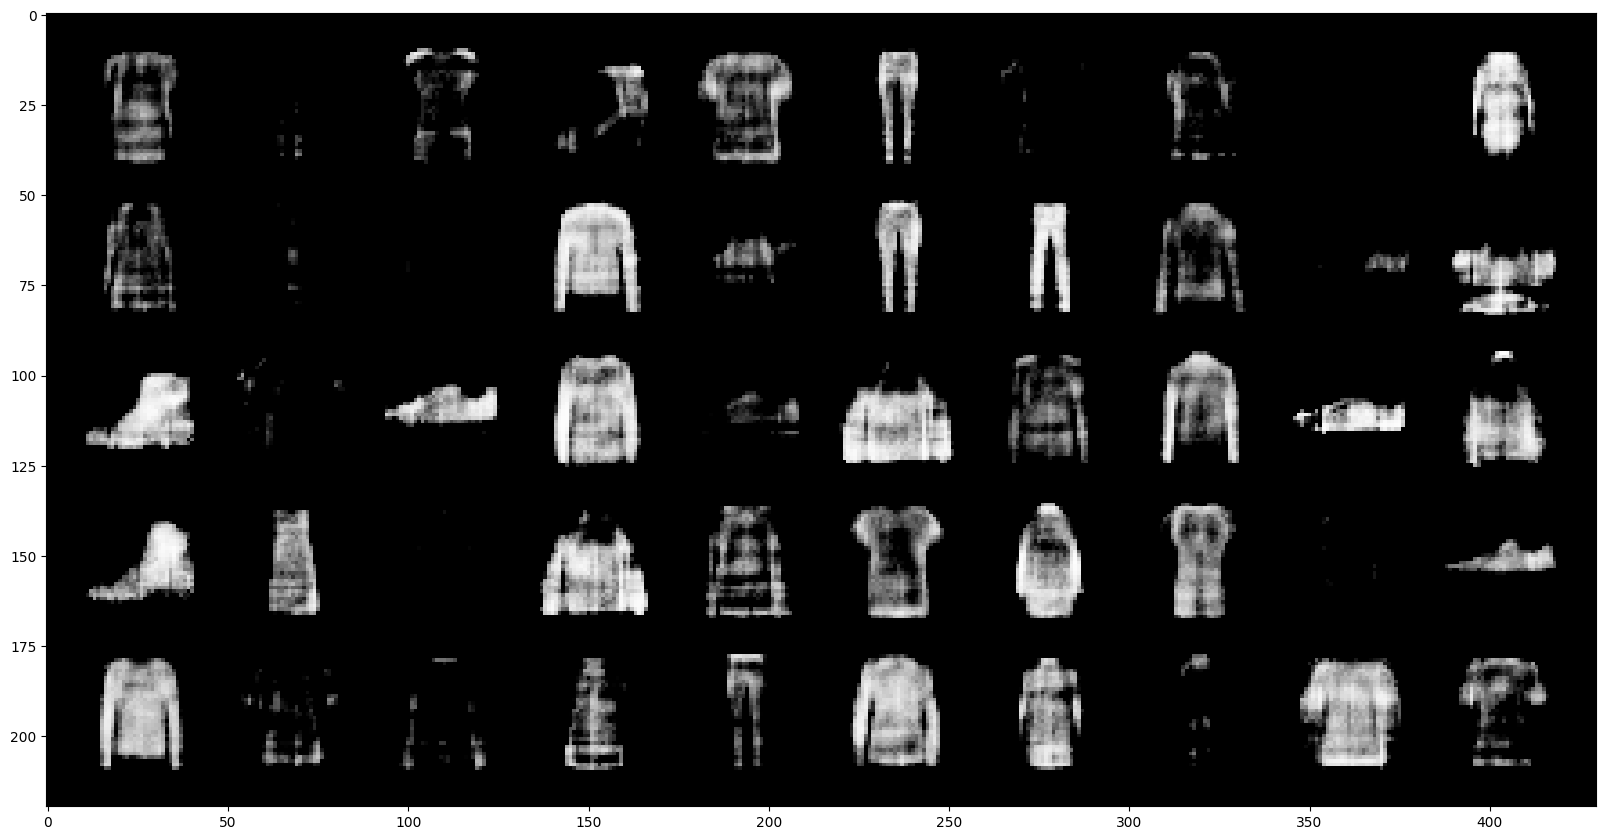

In [26]:
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms as transforms
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
from IPython.display import clear_output
""" So generally both torch.Tensor and torch.cuda.Tensor are equivalent. You can do everything you like with them both.
The key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory.
Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU."""

##############################################
# Defining all hyperparameters
##############################################


class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


hp = Hyperparameters(
    n_epochs=200,
    batch_size=128,
    lr=0.00005,
    n_cpu=8,
    latent_dim=100,
    img_size=32,
    channels=1,
    n_critic=5,
    clip_value=0.01,
    sample_interval=400,
)

##############################################
# Setting Root Path for Google Drive or Kaggle
##############################################
root_path ="data"

train_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        root_path,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(hp.img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        ),
    ),
    batch_size=hp.batch_size,
    shuffle=True,
)


##############################################
# INITIALIZE Generator and Critic
##############################################

img_shape = (hp.channels, hp.img_size, hp.img_size)

generator = Generator(img_shape, hp.latent_dim)
critic = Critic(img_shape)

if cuda:
    generator.cuda()
    critic.cuda()

##############################################
# Defining all Optimizers
##############################################

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=hp.lr)
optimizer_D = torch.optim.RMSprop(critic.parameters(), lr=hp.lr)


##############################################
# Initialize weights
##############################################
generator.apply(weights_init_normal)
critic.apply(weights_init_normal)


def train():
    for epoch in range(hp.n_epochs):
        for i, (imgs, _) in enumerate(train_dataloader):
            g_loss = torch.tensor(0.0)  # Initialize g_loss

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            #########################
            #  Train Critic
            #########################

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z).detach()

            """ The math for the loss functions for the critic and generator is:
                Critic Loss: D(x) - D(G(z))
                -D(x) + D(G(z))
                Generator Loss: D(G(z))
                Now for the Critic Loss, as per the Paper, we have to maximize the expression.
                So, arithmetically, maximizing an expression, means minimizing the -ve of that expression
                i.e. -(D(x) - D(G(z))) which is -D(x) + D(G(z)) i.e. -D(real_imgs) + D(G(real_imgs))
            """
            d_loss = -torch.mean(critic(real_imgs)) + torch.mean(critic(fake_imgs))

            d_loss.backward()
            optimizer_D.step()

            """ Clip weights of critic to avoid vanishing/exploding gradients in the
            critic/critic. """
            for p in critic.parameters():
                p.data.clamp_(-hp.clip_value, hp.clip_value)

            """ In WGAN, we update Critic more than Generator
            Train the generator every n_critic iterations
            we need to increase training iterations of the critic so that it works to
            approximate the real distribution sooner.
            """
            if i % hp.n_critic == 0:
                #########################
                #  Train Generators
                #########################
                optimizer_G.zero_grad()

                # Generate a batch of images
                fake_images_from_generator = generator(z)
                # Adversarial loss
                g_loss = -torch.mean(critic(fake_images_from_generator))

                g_loss.backward()
                optimizer_G.step()

            ##################
            #  Log Progress
            ##################

            batches_done = epoch * len(train_dataloader) + i

            if batches_done % hp.sample_interval == 0:
                clear_output()
                print(f"Epoch:{epoch}:It{i}:DLoss{d_loss.item()}:GLoss{g_loss.item()}")
                visualise_output(fake_images_from_generator.data[:50], 10, 10)


train()